# Methane in electric field
As a simple toy model for so3 flows

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

import mdtraj as md
import nglview as nv

In [2]:
import openmm
import openmm.app
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

## Create the system
files adapted from https://github.com/kevinjuan25/autoencoders_project/tree/master/example_simulations/methane_in_water_gmx

In [3]:
class MethaneModel():
    def __init__(self, external_field=None):
        """

        Parameters
        ----------
        external_field : openmm.unit.Quantity (energy / (charge * distance))
            The strenght of the external electric field along y
            
        """
        
        gro = openmm.app.GromacsGroFile('methane.gro')
        top = openmm.app.GromacsTopFile('methane.top')
        system = top.createSystem(constraints=openmm.app.HBonds, removeCMMotion=True)
        
        if external_field is not None:
            potential = "-q*E*y"
            force = openmm.CustomExternalForce(potential)
            force.addPerParticleParameter("q")
            force.addGlobalParameter("E", external_field)
            nonbonded = [f for f in system.getForces() if isinstance(f, openmm.NonbondedForce)][0]
            for i in range(system.getNumParticles()):
                charge, sigma, epsilon = nonbonded.getParticleParameters(i)
                force.addParticle(i, [charge])
            system.addForce(force)
        
        self.system = system
        self.topology = top.topology
        self.mdtraj_topology = md.Topology.from_openmm(self.topology)
        self.positions = np.array(gro.positions / unit.nanometer)
        self.n_molecules = 1
        self.n_atoms = self.positions.shape[0] // self.n_molecules

In [10]:
field = 10000. * unit.kilojoule_per_mole / unit.elementary_charge / unit.nanometer
model = MethaneModel(field)

nv.show_mdtraj(md.Trajectory(model.positions, model.mdtraj_topology))
model.system.getForces()

[<openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f30bc2db5d0> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x7f30bc2be040> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7f30bc2bef70> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x7f30bc2be0a0> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7f30bc2bdaa0> >,
 <openmm.openmm.CustomExternalForce; proxy of <Swig Object of type 'OpenMM::CustomExternalForce *' at 0x7f30bc2bf6c0> >]

## Run MD simulation

In [11]:
## plotting functions

def plot_traj(pos):
    traj = pos[:,1,1]
    plt.figure(figsize=(14, 4))
    
    plt.subplot(1,2,1)
    plt.plot(traj, '.')
    plt.xlim(0, len(traj))
    plt.xlabel('Time')
    plt.ylabel('y')
    
    plt.subplot(1,2,2)
    plt.hist(traj, bins='auto')
    plt.xlabel('y')
    
    plt.suptitle('projection along y of H1 position')
    plt.show()

def plot_energy(ene):
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    plt.plot(ene, ".")
    plt.xlim(0, len(ene))
    plt.xlabel("time")
    plt.ylabel("energy [kJ/mol]")

    plt.subplot(1, 2, 2)
    plt.hist(ene, bins="auto")
    plt.xlabel("energy [kJ/mol]")

    plt.show()

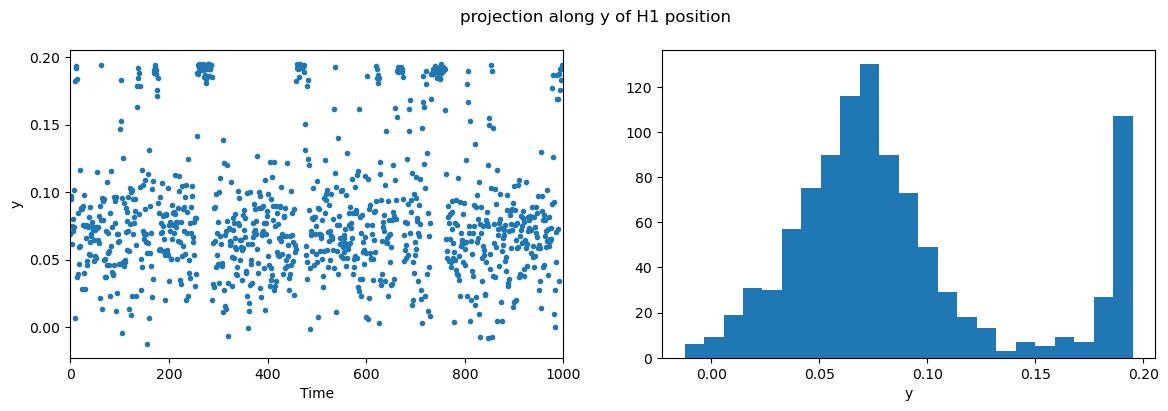

In [12]:
temp = 100
pace = 500
n_iter = 1000

integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 1/unit.picosecond, 1*unit.femtosecond)
simulation = openmm.app.Simulation(model.topology, model.system, integrator)
simulation.context.setPositions(model.positions)
MDpos = np.full((n_iter, *model.positions.shape), np.nan)
MDene = np.full(n_iter, np.nan)

for n in range(n_iter):
    simulation.step(pace)
    MDpos[n] = simulation.context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(unit.nanometers)
    MDene[n] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    if (n + 1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_traj(MDpos)        

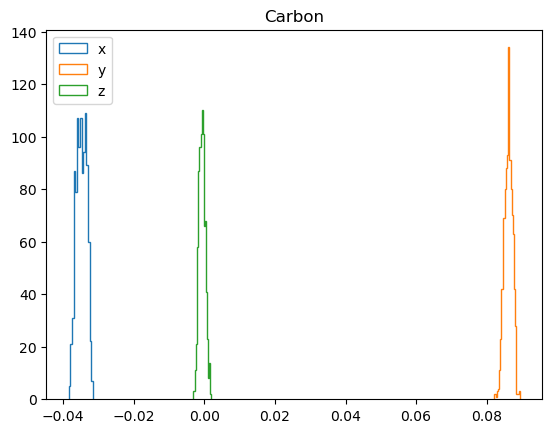

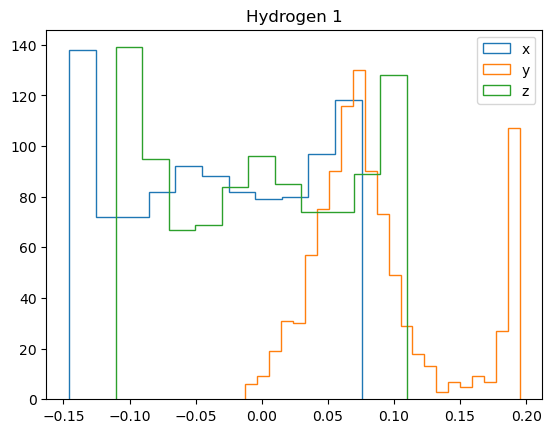

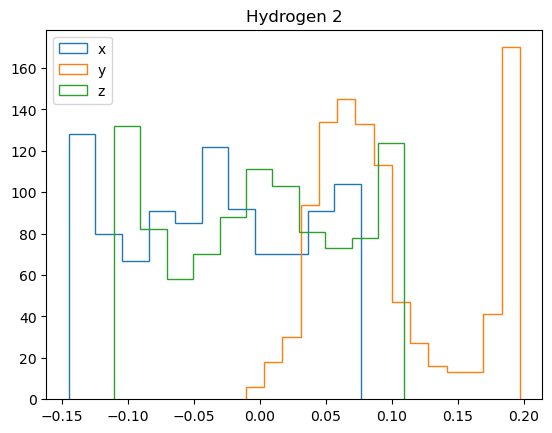

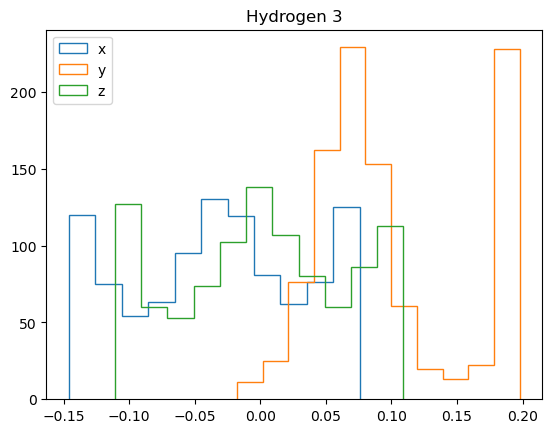

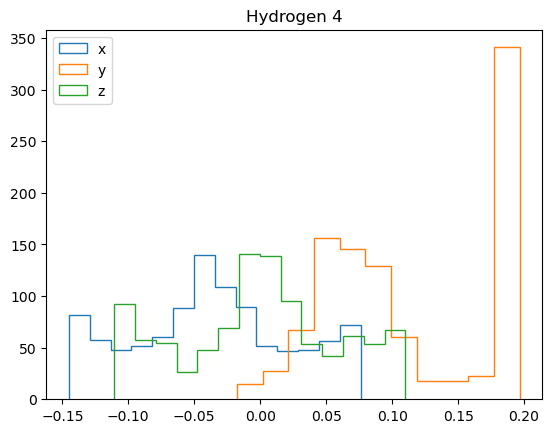

In [13]:
hist_opt = {'bins': 'auto', 'histtype': 'step'}
labels = ['x', 'y', 'z']
for i in range(model.n_atoms):
    if i == 0:
        plt.title('Carbon')
    else:
        plt.title(f'Hydrogen {i}')
    for j in range(3):
        plt.hist(MDpos[:,i,j], **hist_opt, label=labels[j])
    plt.legend()
    plt.show()

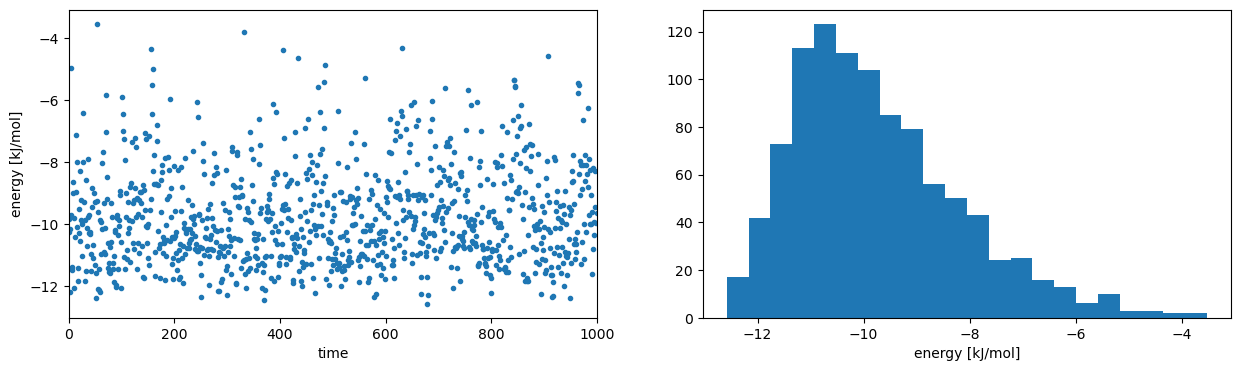

NGLWidget(max_frame=999)

In [14]:
plot_energy(MDene)
nv.show_mdtraj(md.Trajectory(MDpos, model.mdtraj_topology))

mean_CH1 = 0.011881,  std_CH1 = 4.52509e-09
mean_CH2 = 0.011881,  std_CH2 = 4.46662e-09
mean_CH3 = 0.011881,  std_CH3 = 4.33283e-09
mean_CH4 = 0.011881,  std_CH4 = 4.11352e-09


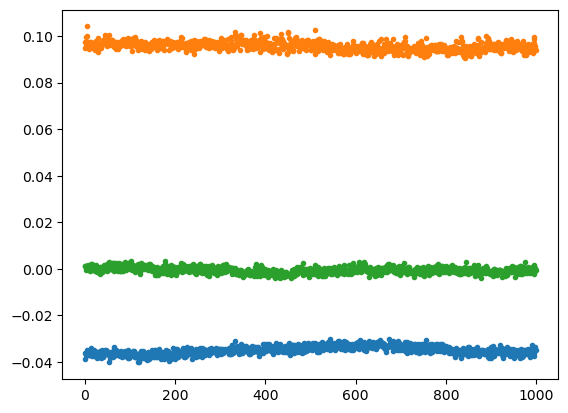

In [15]:
## double check that bonds are fixed
for i in range(1, model.n_atoms):
    CHdistance = np.sum(np.power(MDpos[:,0]-MDpos[:,i], 2), axis=-1)
    print(f'mean_CH{i} = {CHdistance.mean():g},  std_CH{i} = {CHdistance.std():g}')
    # plt.plot(CHdistance, '.')
# plt.show()

## as well as the center of mass
plt.plot(MDpos.mean(axis=1), '.')
plt.show()
